<a href="https://colab.research.google.com/github/raffiilham/Machine_Learning_Ganjil/blob/main/UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UTS MACHINE LEARNING**

NAMA KELOMPOK :
1. AGUSTY LABDANAYOGA/01/2241720215
2. ICHA DEWI PUTRIANA / 10 / 2241720069
3. IKHWANDI
4. RAFI

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset [CISIA Webface](https://www.kaggle.com/datasets/ntl0601/casia-webface). Perhatian! Dataset ini cukup besar (2.8Gb) dari 500.000 gambar dan 10.575 subjek (label)
Spesifikasi pengerjaan UTS yang harus dipehuni adalah,

1. Pelajari tentang CISIA Webface!
2. Dikarenakan data gambar dari CISIA masih dalam 1 direktori besar, Anda perlu melakukan proses split antara data latih dan data uji. Anda dapat melakukan ini secara manual (langsung dari direktori) atau secara logikal dengan listing direktori. (10 poin)
2. Lakukan proses pra pengolahan data. Anda wajib dapat menjelaskan proses pra pengolahan data yang dilakukan. (20 poin)
3. Lakukan proses ekstraksi fitur. Fitur yang digunakan bebas. Anda wajib dapat menjelasakan fitur yang digunakan (30 poin)
4. Buat model NN dengan arsitektur yang kelompok Anda rancang sendiri. Model arsitektur bebas (jumlah layer, jumlah node, fungsi aktiviasi). (30 poin)
6. Evaluasi performa model NN kelompok Anda dengan metrik akurasi, *precision*, *recall*, dan *F1-Score*. Jelaskan maksud dari metric-metric tersebut!

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

# Preparation

In [ ]:

# Import libraries
import numpy as np
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:",path)

100%|██████████| 2.53G/2.53G [00:26<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


# Load Data

In [ ]:
'''
    Bagian ini dapat Anda gunakan untuk melakukan proses loading data
    dan juga proses split antara data latih dan data uji berdasarkan direktori gambar
'''

'\n    Bagian ini dapat Anda gunakan untuk melakukan proses loading data\n    dan juga proses split antara data latih dan data uji berdasarkan direktori gambar\n'

In [ ]:
# Jalur direktori dataset yang diunduh
dataset_path = path  # pastikan `path` mengarah ke direktori yang benar

# Memastikan direktori dataset ada
if os.path.exists(dataset_path):
    print("Dataset ditemukan di path:", dataset_path)

    # Melihat isi direktori (menampilkan beberapa file/folder)
    files = os.listdir(dataset_path)
    if files:
        print(f"{len(files)} file ditemukan dalam dataset. Contoh beberapa file:")
        print(files[:5])  # Menampilkan 5 file/folder pertama
    else:
        print("Direktori ada tetapi kosong.")
else:
    print("Dataset belum diunduh atau path salah.")

Dataset ditemukan di path: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1
2 file ditemukan dalam dataset. Contoh beberapa file:
['casia-webface.txt', 'casia-webface']


In [ ]:
# Tentukan jalur dataset
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

# Memeriksa apakah dataset path ada dan menghitung gambar
image_count = 0

if os.path.exists(dataset_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Memeriksa format gambar
                image_count += 1

print(f"Jumlah gambar ditemukan: {image_count}")


Jumlah gambar ditemukan: 490623


In [ ]:
# Membaca file casia-webface.txt untuk menghitung label unik
label_set = set()

# Jalur ke file teks yang berisi informasi label
file_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface.txt"

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) > 1:  # Pastikan ada cukup informasi
            label = parts[0]  # Mengambil label dari baris
            label_set.add(label)  # Menambahkan label ke set (automatis menghindari duplikasi)

# Menampilkan jumlah label unik
print(f"Jumlah label unik ditemukan: {len(label_set)}")


Jumlah label unik ditemukan: 10537


In [ ]:
# Function to scan directory and collect images
def scan_directory(base_path, max_samples=10000):
    images = []
    labels = []
    sample_count = 0

    print(f"Scanning directory: {base_path}")

    # Iterate through each subfolder (label)
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)

        # Skip if not a directory
        if not os.path.isdir(label_path):
            continue

        # Scan images in label folder
        for image_name in os.listdir(label_path):
            if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(label_path, image_name)
                images.append(image_path)
                labels.append(label)
                sample_count += 1

                # Print progress every 1000 images
                if sample_count % 1000 == 0:
                    print(f"Processed {sample_count} images...")

                # Stop if reached max_samples
                if sample_count >= max_samples:
                    print(f"Reached maximum sample size of {max_samples}")
                    return images, labels

    print(f"Total images collected: {len(images)}")
    return images, labels

# Path to dataset
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

# Load dataset
print("Loading dataset...")
images, labels = scan_directory(dataset_path, max_samples=10000)

if len(images) == 0:
    raise ValueError("No images were loaded successfully")

print(f"Dataset loaded successfully with {len(images)} images")

Loading dataset...
Scanning directory: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface
Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...
Reached maximum sample size of 10000
Dataset loaded successfully with 10000 images


# Preprocessing

In [ ]:
# Function for preprocessing
def preprocess_image(image_path, target_size=(64, 64)):
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            return None

        # Convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        img = cv2.resize(img, target_size)

        # Normalize
        img = img / 255.0

        # Add channel dimension untuk 3D
        img = np.expand_dims(img, axis=-1)

        return img

    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
print(f"Train set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")

# Preprocessing data
print("\nPreprocessing data...")
X_train_processed = []
X_test_processed = []

# Process training data
for i, img_path in enumerate(X_train):
    if i % 100 == 0:  # Progress update
        print(f"Processing training image {i}/{len(X_train)}")
    img = preprocess_image(img_path)
    if img is not None:
        X_train_processed.append(img)

# Process testing data
for i, img_path in enumerate(X_test):
    if i % 100 == 0:  # Progress update
        print(f"Processing testing image {i}/{len(X_test)}")
    img = preprocess_image(img_path)
    if img is not None:
        X_test_processed.append(img)

X_train_processed = np.array(X_train_processed)
X_test_processed = np.array(X_test_processed)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed testing shape: {X_test_processed.shape}")

# Label encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Train set: 8000 images
Test set: 2000 images

Preprocessing data...
Processing training image 0/8000
Processing training image 100/8000
Processing training image 200/8000
Processing training image 300/8000
Processing training image 400/8000
Processing training image 500/8000
Processing training image 600/8000
Processing training image 700/8000
Processing training image 800/8000
Processing training image 900/8000
Processing training image 1000/8000
Processing training image 1100/8000
Processing training image 1200/8000
Processing training image 1300/8000
Processing training image 1400/8000
Processing training image 1500/8000
Processing training image 1600/8000
Processing training image 1700/8000
Processing training image 1800/8000
Processing training image 1900/8000
Processing training image 2000/8000
Processing training image 2100/8000
Processing training image 2200/8000
Processing training image 2300/8000
Processing training image 2400/8000
Processing training image 2500/8000
Processi

# Features Extraction

In [ ]:
# Convert to categorical
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Build Model

In [ ]:
# Build model function
def build_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Compile and train model
print("\nBuilding and training model...")
input_shape = (64, 64, 1)  # Grayscale images
num_classes = len(np.unique(y_train_encoded))
model = build_model(input_shape, num_classes)

# Model summary
model.summary()


Building and training model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,410,987 (16.83 MB)

 Trainable params: 4,409,515 (16.82 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    )
]

# Train model
history = model.fit(
    X_train_processed,
    y_train_cat,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 495ms/step - accuracy: 0.0752 - loss: 5.4525 - val_accuracy: 0.0338 - val_loss: 6.1559 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 514ms/step - accuracy: 0.1823 - loss: 4.0784 - val_accuracy: 0.1056 - val_loss: 5.5131 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 520ms/step - accuracy: 0.3246 - loss: 3.1839 - val_accuracy: 0.2688 - val_loss: 3.6490 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 514ms/step - accuracy: 0.4296 - loss: 2.5800 - val_accuracy: 0.3431 - val_loss: 3.3585 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 526ms/step - accuracy: 0.5353 - loss: 2.0456 - val_accuracy: 0.4212 - val_loss: 2.7362 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 478ms/step - accuracy: 0.6307 - loss: 1.5975 - val_accuracy: 0.4394 - val_loss: 2.7130 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 503ms/step - accura

# Evaluation


Evaluating model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step

Model Performance Metrics:
Accuracy: 0.5965
Precision: 0.6011
Recall: 0.5965
F1-Score: 0.5722


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


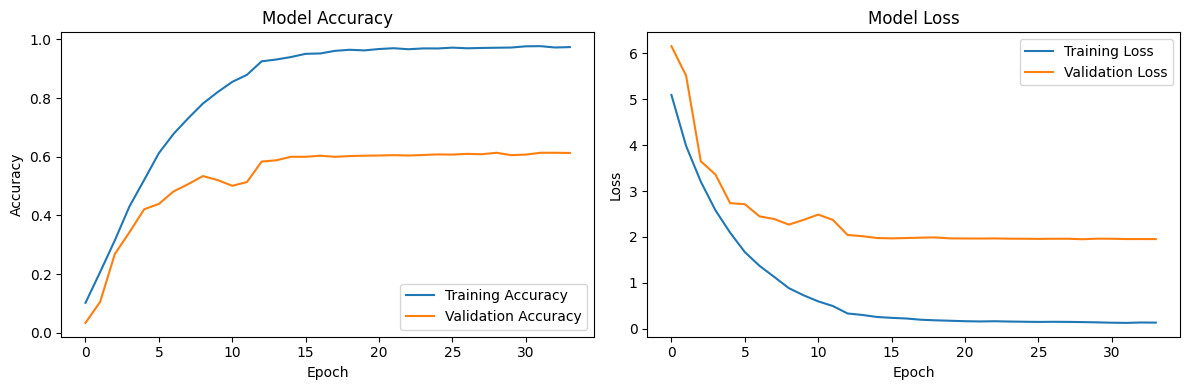

In [ ]:
# Evaluation
print("\nEvaluating model...")
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()